# **Object Detection for Pedestrian Recognition: A Comparative Investigation of Modern Algorithms**

# **1. Required Libraries and Modules**

This section covers the necessary libraries and modules that are used in the project. These components are essential for various tasks, such as data manipulation, image processing, visualization, and implementing the object detection model. We'll import and discuss the key libraries and modules that play a crucial role in building and running the project.


In [58]:
# Required Libraries and Modules
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.io import read_image

import torch
import torchvision
from torchvision import transforms as T
from torchvision.transforms import functional as F
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Additional Libraries
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset
import torchvision.transforms as T

import matplotlib.pyplot as plt
import matplotlib.patches as patches


## **1.2 Define Paths and Directories**
For seamless data loading and model setup, it's crucial to define the paths to the dataset images and masks. These paths will be used to locate and load the necessary data.

In [59]:
global imagePngPath, masksPath

test_image_path = 'test/crosswalk-featured.jpg'

imagePngPath = "dataset/PennFudanPed/PNGImages/"
masksPath = "dataset/PennFudanPed/PedMasks/"

resnet_model_path = "models/fasterRCNN-epoch200-pytorch.pth"
mobilenet_model_path = "models/fasterRCNN-mobilenet-v3-epoch200.pth"
ssd_model_path = "models/ssd-epoch100.pth"


# **2. Data Preprocessing and Custom Dataset**

### **Creating a Custom Dataset for Object Detection**

This section focuses on creating a custom dataset class called `ModDataset` for object detection. The dataset is designed to load images and corresponding masks, perform data preprocessing, and prepare the data in a format suitable for training the object detection model. The class includes methods to handle loading images and masks, applying transformations, and formatting the data into target tensors for training.


In [60]:
class ModDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.imagePaths = image_paths
        self.maskPaths = mask_paths
        self.transform = transform

    def __getitem__(self, idx):
        imagePath = imagePngPath + self.imagePaths[idx]
        maskPath = masksPath + self.maskPaths[idx]

        img = Image.open(imagePath).convert("RGB")
        mask = Image.open(maskPath)
        mask = np.array(mask)

        mask_pil = Image.fromarray(mask)


        # Apply the resize transform if provided
        if self.transform:
            img = self.transform(img)
            mask = self.transform(mask_pil)

        # Convert mask back to numpy array
        mask = np.array(mask_pil)


        obj_ids = np.unique(mask)
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)

        masks = np.zeros((num_objs, mask.shape[0], mask.shape[1]))
        for i, obj_id in enumerate(obj_ids):
            masks[i][mask == obj_id] = 1

        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        # masks = torch.as_tensor(masks, dtype=torch.uint8)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        # target["masks"] = masks

        return T.ToTensor()(img), target

    def __len__(self):
        return len(self.imagePaths)


# **3. Data Loading and Preprocessing**

### **Loading and Preprocessing the Penn-Fudan Dataset**

In this section, we'll focus on loading and preprocessing the Penn-Fudan dataset. We'll set the paths to the image and mask directories and organize the data into a suitable format for further analysis. The dataset will be loaded using the `ModDataset` class, which is designed to handle image and mask pairs. This step prepares the data for subsequent steps, including training, validation, and model evaluation.


In [61]:
images = sorted(os.listdir(imagePngPath))
masks = sorted(os.listdir(masksPath))

dataset = ModDataset(images, masks)

## **3.1 Visualizing Sample Images**

To gain insight into the Penn-Fudan dataset, we visualize a subset of sample images and their corresponding targets. In this subsection, we load a few samples using the `dataset` object and display them side by side. Each row contains four images, allowing us to observe the raw input data before any processing. This visualization aids in understanding the nature of the dataset and the characteristics of the images we will work with.


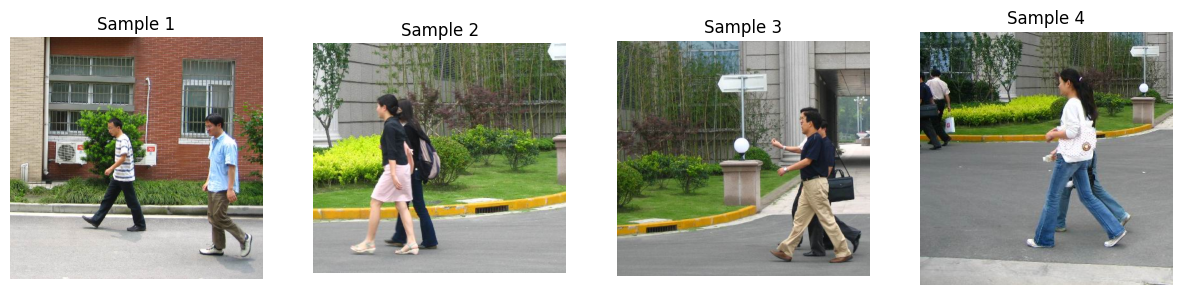

In [62]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
for i, ax in enumerate(axes):
    image, target = dataset[i]
    ax.imshow(image.permute(1, 2, 0))
    ax.set_title(f"Sample {i+1}")
    ax.axis("off")
plt.show()

### **Optional: Mounting Google Drive**

If you are using Google Colab and your dataset is stored in Google Drive, you can use the following code snippet to mount your Google Drive and access the dataset directory. This step is essential if your dataset is not stored within the Colab environment and needs to be accessed from an external source such as Google Drive.


In [63]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **3.2 Visualizing a Sample Image with Bounding Boxes**

To gain a better understanding of how the bounding boxes are applied to the dataset, we will visualize a sample image with its associated bounding box. This will provide a visual representation of how the object detection labels are mapped onto the images. The code snippet below demonstrates how to load a sample image and its corresponding mask, extract bounding box coordinates from the mask, and display the image along with the bounding box.


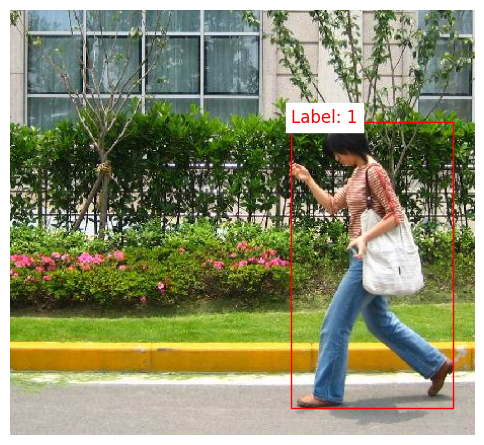

In [64]:
sample_idx = 10

image_filename = images[sample_idx]
mask_filename = masks[sample_idx]

image_path = os.path.join(imagePngPath, image_filename)
mask_path = os.path.join(masksPath, mask_filename)

sample_image = read_image(image_path)
sample_mask = read_image(mask_path)

# Display the image with bounding boxes
def display_image_with_boxes(image, boxes, labels):
    fig, ax = plt.subplots(1, figsize=(6, 6))
    ax.imshow(image.permute(1, 2, 0))

    for box, label in zip(boxes, labels):
        xmin, ymin, xmax, ymax = box
        rect = patches.Rectangle(
            (xmin, ymin), xmax - xmin, ymax - ymin,
            linewidth=1, edgecolor='r', facecolor='none'
        )
        ax.add_patch(rect)
        ax.text(
            xmin, ymin, f"Label: {label}",
            color='r', fontsize=12, backgroundcolor='w'
        )

    ax.axis('off')
    plt.show()

# Get the bounding boxes and labels from the mask
non_zero_pixels = sample_mask[0].nonzero()
boxes = [
    [
        min(non_zero_pixels[:, 1]),
        min(non_zero_pixels[:, 0]),
        max(non_zero_pixels[:, 1]),
        max(non_zero_pixels[:, 0])
    ]
]
labels = [1]  # Assuming one class

# Display the image with the detected bounding box
display_image_with_boxes(sample_image, boxes, labels)


## **3.3 Dataset Splitting for Training and Validation**

To facilitate the training and validation of the object detection model, we need to split the dataset into training and validation sets. The provided code snippet demonstrates how to randomly split the dataset into training and validation subsets based on a specified ratio. Additionally, it defines the `batchSize` for the data loaders to process the data efficiently during training. By splitting the dataset, we can ensure that the model is trained on one portion of the data and validated on another, allowing us to assess its performance accurately.


In [65]:
def split_dataset(images, masks, train_ratio=0.9):
    num_samples = int(train_ratio * len(images))
    num_samples = num_samples if num_samples % 2 == 0 else num_samples + 1

    train_indices = np.random.choice(range(len(images)), num_samples, replace=False)
    val_indices = np.setdiff1d(range(len(images)), train_indices)

    train_images = np.array(images)[train_indices]
    val_images = np.array(images)[val_indices]
    train_masks = np.array(masks)[train_indices]
    val_masks = np.array(masks)[val_indices]

    return train_images, val_images, train_masks, val_masks


train_ratio = 0.8
batchSize = 4

trainImages, valImages, trainMasks, valMasks = split_dataset(images, masks, train_ratio)

## **3.4 Data Loading and Augmentation**

This section covers the essential steps to load and augment the dataset for training the object detection model. The provided code demonstrates how to prepare the data by performing the following tasks:

1. Define Transformation: A series of transformations are applied to the dataset to preprocess and augment the images. These transformations include resizing the images, applying random horizontal flips, and converting them into tensors.

2. Custom Collate Function: The custom `customCollate` function is created to handle batch collation during data loading. It ensures that the dataset is properly organized and presented to the model for training.

3. Training and Validation Data Loaders: The training and validation datasets are instantiated using the `ModDataset` class. Subsequently, data loaders are created for both datasets, enabling efficient loading of batches during training and validation. The `shuffle` parameter ensures that the data is shuffled before each epoch to improve the training process. Additionally, the `pin_memory` parameter is set based on the availability of GPU for optimized data transfer.

By preparing the data through these steps, the model is provided with properly formatted inputs for training and evaluation.


In [66]:
import torch.utils.data as data

transform = T.Compose([
    T.Resize((800, 800)),
    T.RandomHorizontalFlip(0.5),
    T.ToTensor(),
])

def customCollate(data):
    return data

trainDataset = ModDataset(trainImages, trainMasks)
trainDataLoader = data.DataLoader(trainDataset,
                                  batch_size=batchSize,
                                  shuffle=True,
                                  collate_fn=customCollate,
                                  num_workers=1,
                                  pin_memory=True if torch.cuda.is_available() else False)

# Create validation DataLoader
valDataset = ModDataset(valImages, valMasks)
valDataLoader = data.DataLoader(valDataset,
                                batch_size=batchSize,
                                shuffle=True,
                                collate_fn=customCollate,
                                num_workers=1,
                                pin_memory=True if torch.cuda.is_available() else False)


## **4. Device Configuration**

Before delving into the model implementation, the code snippet provided configures the device for training. The device is set to use CUDA if available; otherwise, it falls back to using the CPU. This step ensures that the model and data are appropriately placed on the hardware for efficient computation during training.


In [67]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# **5. Model Configuration and Loading Pre-trained Weights**

## **5.1 Loading Pretrained Faster R-CNN with ResNet-50**

In this section, the code configures the object detection model architecture and loads pre-trained weights. Specifically, a Faster R-CNN model with a ResNet-50 backbone is selected for the task. The model is set to evaluation mode using `.eval()`, which is essential when using it for inference. The pre-trained weights of the model are loaded from the specified path to enable the detection of objects in images.


In [68]:
from torchvision.models import detection

model_resnet50 = detection.fasterrcnn_resnet50_fpn(pretrained=False)
model_resnet50.roi_heads.box_predictor = detection.fasterrcnn_resnet50_fpn(num_classes=2).roi_heads.box_predictor
model_resnet50.load_state_dict(torch.load(resnet_model_path))

model_resnet50.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

## **5.1.1 Model Evaluation - FasterRCNN with ResNet50**

This section demonstrates how to perform object detection on a sample image using the trained Faster R-CNN model with a ResNet-50 backbone. The specified image, "crosswalk-featured.jpg," is loaded and processed to prepare it for inference. The model's predictions are obtained by passing the image through the model using `.forward()`. The function `visualize_predictions` is then used to display the image with predicted bounding boxes. Bounding boxes are drawn around detected objects, with class labels and confidence scores displayed on them. The visualization helps visualize the model's performance in detecting pedestrians in the given image.


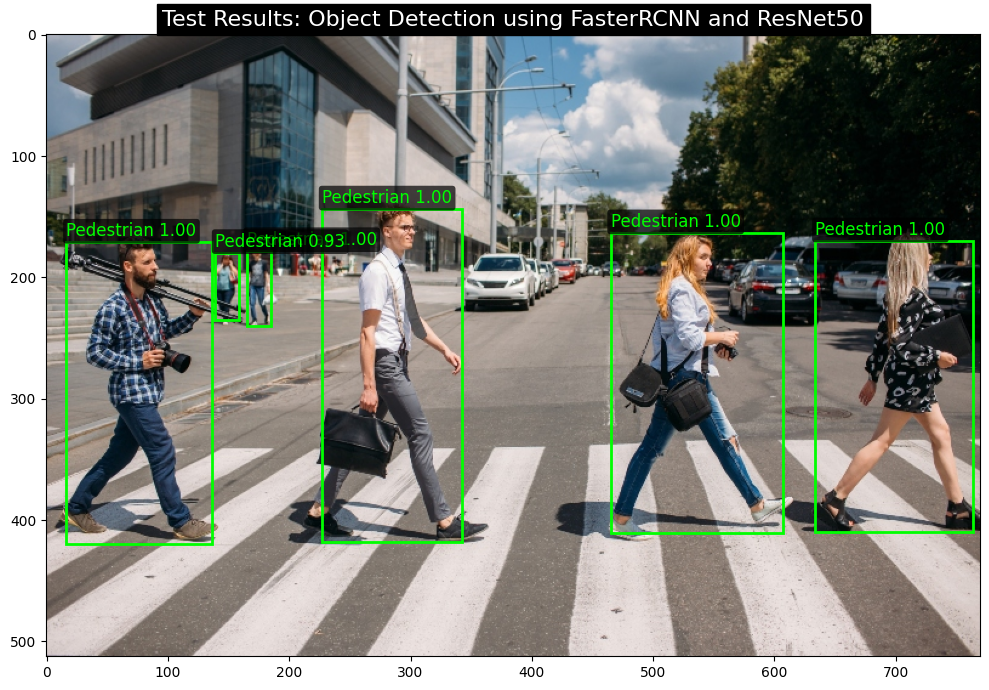

In [69]:

image_path = test_image_path
image = Image.open(image_path).convert("RGB")
image_tensor = F.to_tensor(image).unsqueeze(0)

with torch.no_grad():
    predictions = model_resnet50(image_tensor)


def visualize_predictions(image_tensor, predictions, confidence_threshold=0.5, label_name="Pedestrian", title="Test Result"):
    image = F.to_pil_image(image_tensor.cpu().squeeze(0))  # Move the image tensor back to the CPU for display
    plt.figure(figsize=(10, 8))  # Set the figure size
    plt.imshow(image)
    ax = plt.gca()

    for box, score, label in zip(predictions[0]['boxes'], predictions[0]['scores'], predictions[0]['labels']):
        # Check if the confidence score is above the threshold
        if score >= confidence_threshold:
            box = box.cpu().numpy()
            x, y, x_max, y_max = box
            width = x_max - x
            height = y_max - y
            rect = plt.Rectangle((x, y), width, height, fill=False, color='lime', linewidth=2)
            ax.add_patch(rect)

            # Display label and confidence on the bounding box
            plt.text(
                x, y - 5, f"{label_name} {score:.2f}", color='lime', fontsize=12,
                bbox=dict(facecolor='black', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.2')
            )


    plt.axis()  # Turn off axes
    plt.title(title, fontsize=16, color='white', backgroundcolor='black')  # Add image title
    plt.tight_layout()  # Improve spacing
    plt.show()

# Assuming you have 'image_tensor' and 'predictions' defined
visualize_predictions(image_tensor, predictions, confidence_threshold=0.5, label_name="Pedestrian", title="Test Results: Object Detection using FasterRCNN and ResNet50")


## **5.2 Loading Pretrained Faster R-CNN with MobileNetV3**

In this section, the code demonstrates the process of loading a pre-trained Faster R-CNN model with a MobileNetV3 architecture. The selected model architecture is designed for object detection tasks. The loaded model is then put into evaluation mode using `.eval()` to ensure its proper functioning during inference. Pre-trained weights for the model are loaded from the specified path, enabling the model to perform object detection on input images.


In [70]:
# Load Faster R-CNN model
model_mobilenet = detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=False)
model_mobilenet.roi_heads.box_predictor = detection.fasterrcnn_mobilenet_v3_large_fpn(num_classes=2).roi_heads.box_predictor
model_mobilenet.load_state_dict(torch.load(mobilenet_model_path, map_location=torch.device('cpu')))

model_mobilenet.eval()


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block):

## **5.2.2 Model Evaluation - Faster R-CNN with MobileNetV3**

In this section, the code showcases the process of evaluating the trained Faster R-CNN model with a MobileNetV3 architecture. An input image, "crosswalk-featured.jpg," is utilized for evaluation. The image is loaded and preprocessed, making it suitable for inference with the model. The model's predictions are generated by passing the preprocessed image through the model using the `.forward()` method. The function `visualize_predictions` is then employed to display the image along with predicted bounding boxes. Detected objects are highlighted with bounding boxes, and corresponding class labels and confidence scores are displayed. This visualization provides insights into the model's performance in identifying pedestrians in the specified image.


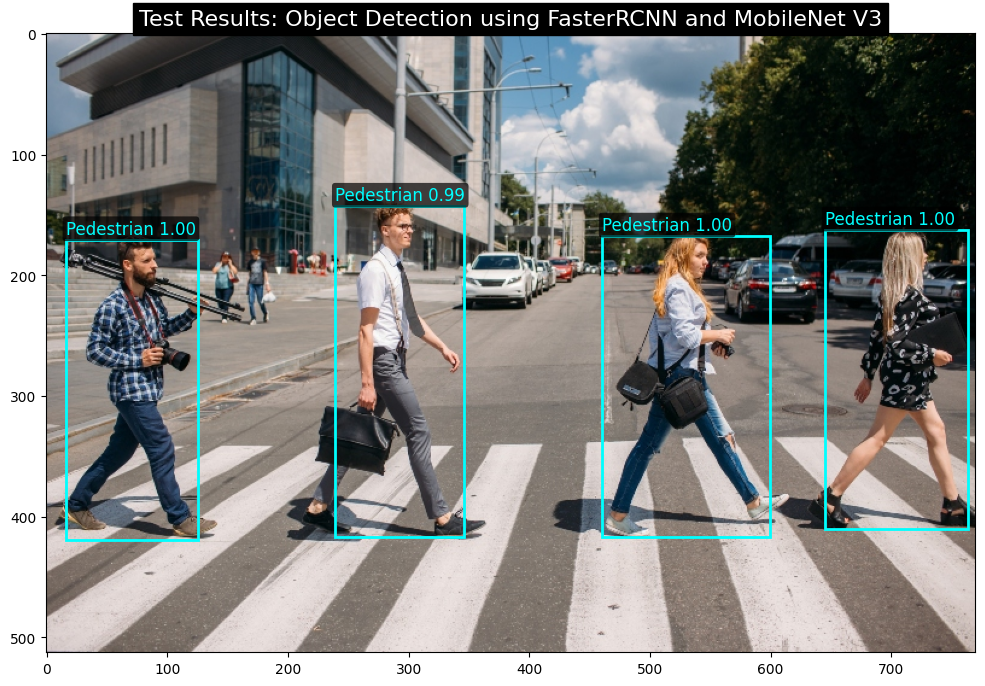

In [71]:
image = Image.open(image_path).convert("RGB")
image_tensor = F.to_tensor(image).unsqueeze(0)

with torch.no_grad():
    predictions = model_mobilenet(image_tensor)


def visualize_predictions(image_tensor, predictions, confidence_threshold=0.5, label_name="Pedestrian", title="Test Result"):
    image = F.to_pil_image(image_tensor.cpu().squeeze(0))  # Move the image tensor back to the CPU for display
    plt.figure(figsize=(10, 8))  # Set the figure size
    plt.imshow(image)
    ax = plt.gca()

    for box, score, label in zip(predictions[0]['boxes'], predictions[0]['scores'], predictions[0]['labels']):
        # Check if the confidence score is above the threshold
        if score >= confidence_threshold:
            box = box.cpu().numpy()
            x, y, x_max, y_max = box
            width = x_max - x
            height = y_max - y
            rect = plt.Rectangle((x, y), width, height, fill=False, color='cyan', linewidth=2)
            ax.add_patch(rect)

            # Display label and confidence on the bounding box
            plt.text(
                x, y - 5, f"{label_name} {score:.2f}", color='cyan', fontsize=12,
                bbox=dict(facecolor='black', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.2')
            )


    plt.axis()  # Turn off axes
    plt.title(title, fontsize=16, color='white', backgroundcolor='black')  # Add image title
    plt.tight_layout()  # Improve spacing
    plt.show()

# Assuming you have 'image_tensor' and 'predictions' defined
visualize_predictions(image_tensor, predictions, confidence_threshold=0.5, label_name="Pedestrian", title="Test Results: Object Detection using FasterRCNN and MobileNet V3")


## **5.3 Loading Pretrained SSD300 with VGG16**

This section showcases the loading and configuration of a pre-trained Single Shot MultiBox Detector (SSD300) model with a VGG16 backbone. The SSD300 model is designed for object detection tasks and is capable of detecting multiple object classes in an image. The loaded model is transferred to the appropriate device (CPU or GPU) using `.to(device)` for efficient inference. The model's pre-trained weights are loaded from the specified path, allowing the model to perform object detection on input images.


In [72]:
from torchvision.models.detection import ssd300_vgg16

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_ssd = ssd300_vgg16(pretrained=False)
num_classes = 2
model_ssd.class_predictor = torch.nn.Conv2d(256, num_classes * 4, kernel_size=(1, 1), stride=(1, 1))
model_ssd.load_state_dict(torch.load(ssd_model_path, map_location=device))
model_ssd.to(device)
model_ssd.eval()

SSD(
  (backbone): SSDFeatureExtractorVGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=

## **5.3.1 Model Evaluation - SSD300 with VGG16**

This section demonstrates the evaluation process for the trained Single Shot MultiBox Detector (SSD300) model with a VGG16 backbone. An input image, "crosswalk-featured.jpg," is used for evaluation purposes. The image is loaded and preprocessed to prepare it for inference using the model. The preprocessed image tensor is transferred to the appropriate device (CPU or GPU) for efficient computation. Predictions are generated by passing the image tensor through the SSD300 model using the `.forward()` method. The function `visualize_predictions` is then employed to display the image with predicted bounding boxes. Detected objects are highlighted with orange bounding boxes, and corresponding class labels and confidence scores are displayed on them. This visualization provides insights into the model's ability to detect pedestrians in the provided image.

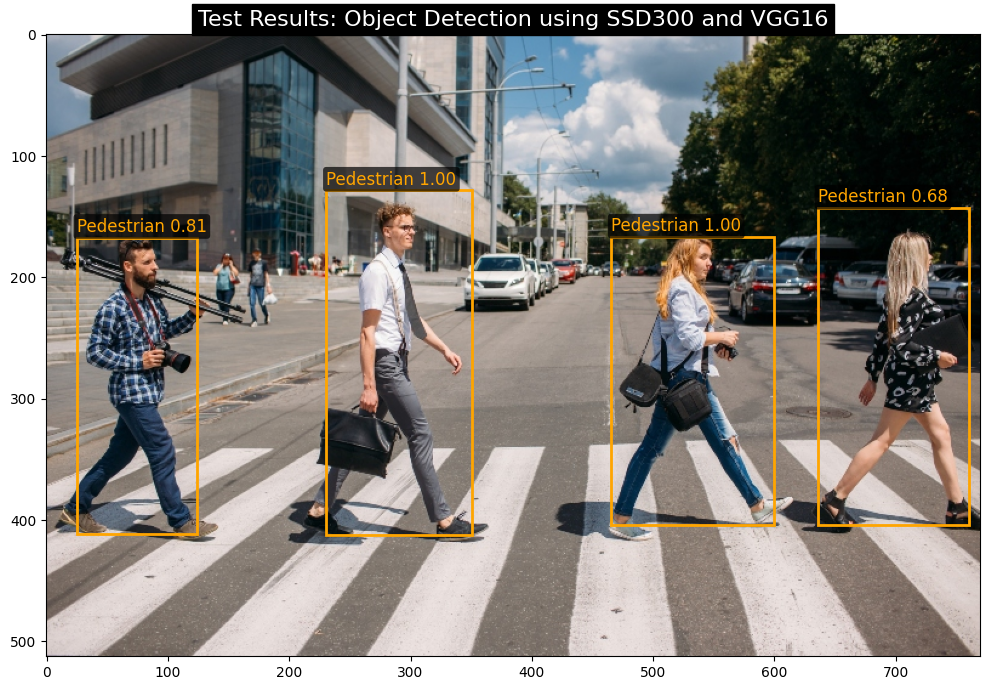

In [73]:
image = Image.open(image_path).convert("RGB")
image_tensor = F.to_tensor(image).unsqueeze(0).to(device)

with torch.no_grad():
    predictions = model_ssd(image_tensor)


def visualize_predictions(image_tensor, predictions, confidence_threshold=0.5, label_name="Pedestrian", title="Test Result"):
    image = F.to_pil_image(image_tensor.cpu().squeeze(0))  # Move the image tensor back to the CPU for display
    plt.figure(figsize=(10, 8))  # Set the figure size
    plt.imshow(image)
    ax = plt.gca()

    for box, score, label in zip(predictions[0]['boxes'], predictions[0]['scores'], predictions[0]['labels']):
        # Check if the confidence score is above the threshold
        if score >= confidence_threshold:
            box = box.cpu().numpy()
            x, y, x_max, y_max = box
            width = x_max - x
            height = y_max - y
            rect = plt.Rectangle((x, y), width, height, fill=False, color='orange', linewidth=2)
            ax.add_patch(rect)

            # Display label and confidence on the bounding box
            plt.text(
                x, y - 5, f"{label_name} {score:.2f}", color='orange', fontsize=12,
                bbox=dict(facecolor='black', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.2')
            )


    plt.axis()  # Turn off axes
    plt.title(title, fontsize=16, color='white', backgroundcolor='black')  # Add image title
    plt.tight_layout()  # Improve spacing
    plt.show()

visualize_predictions(image_tensor, predictions, confidence_threshold=0.5, label_name="Pedestrian", title="Test Results: Object Detection using SSD300 and VGG16")


## **6. Model Analysis**




## **6.1 Faster RCNN with ResNet50 - Intersection over Union (IoU) Metrics**

In this section, we evaluate the performance of the trained Faster R-CNN model with a ResNet-50 backbone using Intersection over Union (IoU) metrics. We assess how well the model's predicted bounding boxes match the ground truth bounding boxes in the validation dataset. The following steps outline the analysis process:

### **Calculating Intersection over Union (IoU)**

To quantitatively measure the accuracy of object detection, we calculate the IoU between predicted bounding boxes and corresponding ground truth bounding boxes for each image in the validation dataset. The code snippet below demonstrates how the IoU values are computed:

In [74]:

import numpy as np
import matplotlib.pyplot as plt

confidence_threshold = 0.6
ious = []

for j, data in enumerate(valDataLoader):
    images = [data[0][0].to(device), data[1][0].to(device)]
    targets = [{k: v.to(device) for k, v in t.items()} for t in [data[0][1], data[1][1]]]
    with torch.no_grad():
      model_resnet50.to(device)
      predictions = model_resnet50(images)

    for pred_box, pred_score, gt_box in zip(predictions[0]['boxes'], predictions[0]['scores'], targets[0]['boxes']):

        if pred_score < confidence_threshold:
          continue

        pred_box = pred_box.cpu().numpy()
        gt_box = gt_box.cpu().numpy()

        # Calculate IoU
        intersection = np.maximum(0, np.minimum(pred_box[2], gt_box[2]) - np.maximum(pred_box[0], gt_box[0])) \
                       * np.maximum(0, np.minimum(pred_box[3], gt_box[3]) - np.maximum(pred_box[1], gt_box[1]))
        union = (pred_box[2] - pred_box[0]) * (pred_box[3] - pred_box[1]) + \
                (gt_box[2] - gt_box[0]) * (gt_box[3] - gt_box[1]) - intersection
        iou = intersection / (union + 1e-10)  # Avoid division by zero
        ious.append(iou)


## **6.1.1 Visualizing IoU Distribution**

We further analyze the IoU distribution to gain insights into the model's performance. The histogram below illustrates the distribution of IoU values:



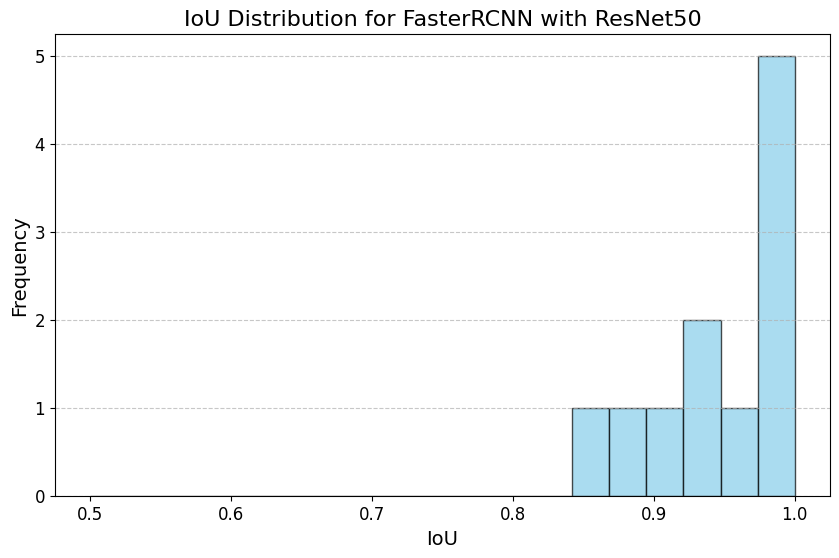

In [75]:
# Set up plot aesthetics
plt.figure(figsize=(10, 6))
plt.hist(ious, bins=np.linspace(0.5, 1, 20), color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('IoU', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('IoU Distribution for FasterRCNN with ResNet50', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## **6.1.2 Comparing Ground Truth vs. Predicted Bounding Boxes**

This section illustrates the process of comparing ground truth bounding boxes with the predicted bounding boxes generated by the trained Faster R-CNN model. An example image from the validation dataset is selected for demonstration. The image, along with its corresponding ground truth boxes and predicted boxes, is displayed to visualize the model's performance.



box [387.40778 189.06401 550.6545  477.2981 ]
gt_boxes[0] [388. 192. 553. 475.]
0.9646703


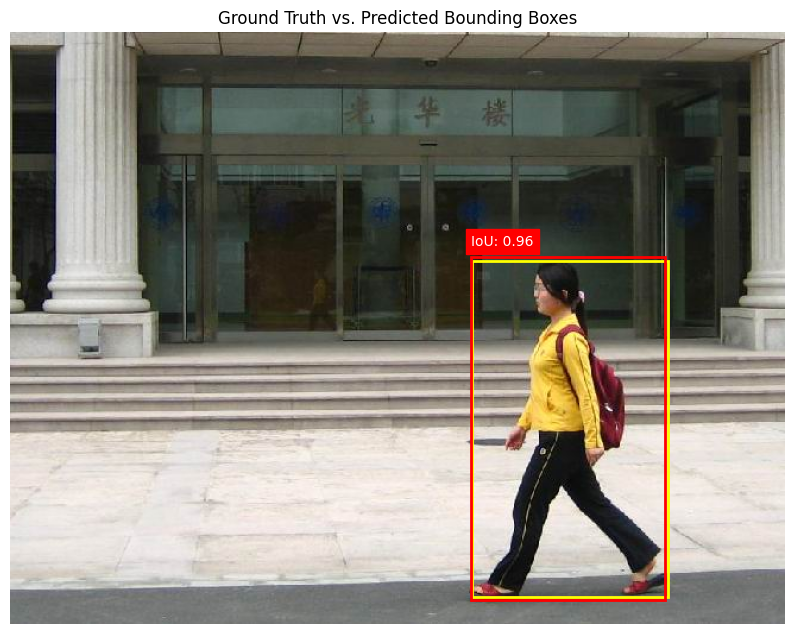

In [76]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.ops.boxes as bops

# Set your desired confidence threshold
confidence_threshold = 0.5

def calculate_iou(boxA, boxB):
    # Calculate IoU between two bounding boxes
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    inter_area = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    boxA_area = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxB_area = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    iou = inter_area / float(boxA_area + boxB_area - inter_area)
    return iou

image_index = 2 # Change this to the desired index

# Get the corresponding image and its target
val_image, val_target = valDataset[image_index]
image = val_image.permute(1, 2, 0).cpu().numpy()
gt_boxes = val_target['boxes'].cpu().numpy()

# Move the model to the same device as the input data
model_resnet50.to(device)

with torch.no_grad():
    predictions = model_resnet50(val_image.unsqueeze(0).to(device))

# Extract predicted boxes and scores
pred_boxes = predictions[0]['boxes'].cpu().numpy()
pred_scores = predictions[0]['scores'].cpu().numpy()

# Create a new figure
plt.figure(figsize=(10, 8))

# Display the validation image
plt.imshow(image)

ax = plt.gca()

# Plot ground truth boxes
for box in gt_boxes:
    x, y, xmax, ymax = box
    width = xmax - x
    height = ymax - y
    rect = patches.Rectangle(
        (x, y), width, height, fill=False, edgecolor='yellow', linewidth=2
    )
    ax.add_patch(rect)

# Plot predicted boxes above the image
for box, score in zip(pred_boxes, pred_scores):
    if score < confidence_threshold:
        continue

    x, y, xmax, ymax = box
    width = xmax - x
    height = ymax - y
    rect = patches.Rectangle(
        (x, y), width, height, fill=False, edgecolor='red', linewidth=2
    )
    ax.add_patch(rect)

    # Calculate IoU and add label
    print("box", box)
    print("gt_boxes[0]", gt_boxes[0])
    # iou = get_iou(box, gt_boxes[0])
    box1 = torch.tensor([box], dtype=torch.float)
    box2 = torch.tensor([gt_boxes[0]], dtype=torch.float)
    iou = bops.box_iou(box1, box2)
    print(iou.numpy()[0][0])
    label = f'IoU: {iou.numpy()[0][0]:.2f}'
    ax.text(
        x, y - 10, label, color='white', backgroundcolor='red', fontsize=10
    )

plt.axis('off')  # Turn off axis
plt.title('Ground Truth vs. Predicted Bounding Boxes')
plt.show()


## **6.2 Faster RCNN with MobileNet - Intersection over Union (IoU) Metrics**

In this section, we assess the performance of the trained Faster R-CNN model with a MobileNet backbone using Intersection over Union (IoU) metrics. This analysis aims to evaluate the degree of alignment between the model's predicted bounding boxes and the ground truth bounding boxes present in the validation dataset.

### **Evaluating IoU Metrics**

We calculate the Intersection over Union (IoU) for each image in the validation dataset. The IoU metric quantifies the overlap between the predicted bounding boxes and the corresponding ground truth bounding boxes.

## **6.2.1 Visualizing IoU Distribution**

We further analyze the IoU distribution to gain insights into the model's performance. The histogram below illustrates the distribution of IoU values:

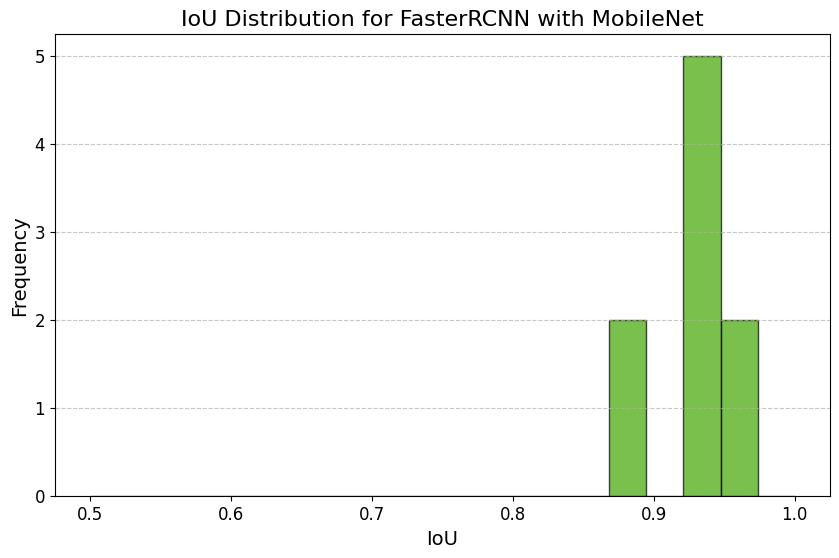

In [77]:
confidence_threshold = 0.6
ious = []  # To store IoU values

for j, data in enumerate(valDataLoader):
    images = [data[0][0].to(device), data[1][0].to(device)]
    targets = [{k: v.to(device) for k, v in t.items()} for t in [data[0][1], data[1][1]]]
    with torch.no_grad():
      model_mobilenet.to(device)
      predictions = model_mobilenet(images)

    for pred_box, pred_score, gt_box in zip(predictions[0]['boxes'], predictions[0]['scores'], targets[0]['boxes']):

        if pred_score < confidence_threshold:
          continue

        pred_box = pred_box.cpu().numpy()
        gt_box = gt_box.cpu().numpy()

        # Calculate IoU
        intersection = np.maximum(0, np.minimum(pred_box[2], gt_box[2]) - np.maximum(pred_box[0], gt_box[0])) \
                       * np.maximum(0, np.minimum(pred_box[3], gt_box[3]) - np.maximum(pred_box[1], gt_box[1]))
        union = (pred_box[2] - pred_box[0]) * (pred_box[3] - pred_box[1]) + \
                (gt_box[2] - gt_box[0]) * (gt_box[3] - gt_box[1]) - intersection
        iou = intersection / (union + 1e-10)  # Avoid division by zero
        ious.append(iou)

# Set up plot aesthetics
plt.figure(figsize=(10, 6))
plt.hist(ious, bins=np.linspace(0.5, 1, 20), color='#41A700', edgecolor='black', alpha=0.7)
plt.xlabel('IoU', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('IoU Distribution for FasterRCNN with MobileNet', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)


plt.show()

## **6.3 SSD300 with VGG16 - Intersection over Union (IoU) Metrics**

In this section, we analyze the performance of the trained SSD300 model with a VGG16 backbone using Intersection over Union (IoU) metrics. The primary objective is to evaluate how accurately the model's predicted bounding boxes align with the ground truth bounding boxes from the validation dataset.

### **Evaluating IoU Metrics for SSD300 with VGG16**

To quantitatively assess the model's object detection accuracy, we calculate the Intersection over Union (IoU) for each image in the validation dataset. The IoU metric quantifies the degree of overlap between the model's predicted bounding boxes and the corresponding ground truth bounding boxes.

## **6.3.1 Visualizing IoU Distribution**

We further analyze the IoU distribution to gain insights into the model's performance. The histogram below illustrates the distribution of IoU values:


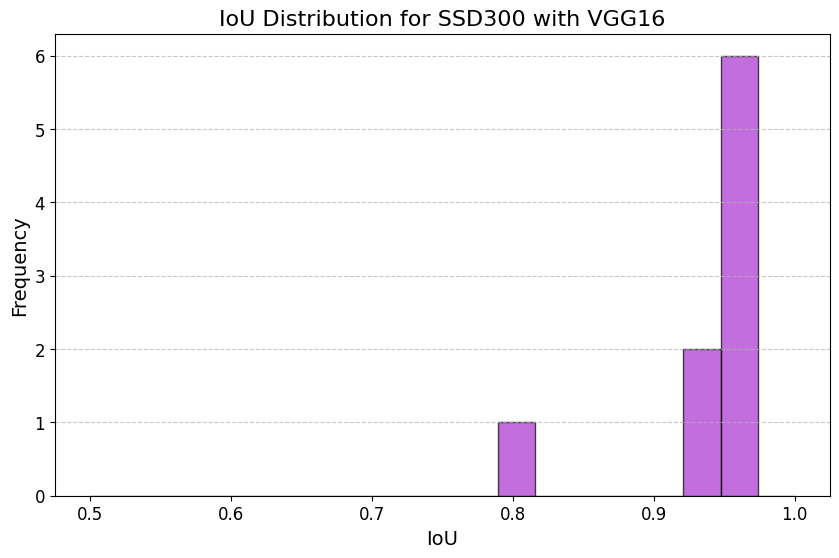

In [78]:

import numpy as np
import matplotlib.pyplot as plt

# # Assuming you have a trained model 'model_resnet50' and a dataset 'valDataLoader'
# model_resnet50.eval()
confidence_threshold = 0.6
ious = []  # To store IoU values

for j, data in enumerate(valDataLoader):
    images = [data[0][0].to(device), data[1][0].to(device)]
    targets = [{k: v.to(device) for k, v in t.items()} for t in [data[0][1], data[1][1]]]
    with torch.no_grad():
      model_ssd.to(device)
      predictions = model_ssd(images)

    for pred_box, pred_score, gt_box in zip(predictions[0]['boxes'], predictions[0]['scores'], targets[0]['boxes']):

        if pred_score < confidence_threshold:
          continue

        pred_box = pred_box.cpu().numpy()
        gt_box = gt_box.cpu().numpy()

        # Calculate IoU
        intersection = np.maximum(0, np.minimum(pred_box[2], gt_box[2]) - np.maximum(pred_box[0], gt_box[0])) \
                       * np.maximum(0, np.minimum(pred_box[3], gt_box[3]) - np.maximum(pred_box[1], gt_box[1]))
        union = (pred_box[2] - pred_box[0]) * (pred_box[3] - pred_box[1]) + \
                (gt_box[2] - gt_box[0]) * (gt_box[3] - gt_box[1]) - intersection
        iou = intersection / (union + 1e-10)  # Avoid division by zero
        ious.append(iou)

# Set up plot aesthetics
plt.figure(figsize=(10, 6))
plt.hist(ious, bins=np.linspace(0.5, 1, 20), color='#A831D1', edgecolor='black', alpha=0.7)
plt.xlabel('IoU', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('IoU Distribution for SSD300 with VGG16', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## **7. Model Inference Time Analysis**

In this section, we delve deeper into the inference time analysis of the object detection models by evaluating their average inference times on the validation dataset. The goal is to assess how long each model takes to process a batch of images and generate predictions.

### **Evaluating Average Inference Time**

To evaluate the average inference time for each model, we execute the following steps:

1. Initialize the list `avg_times` to store the average inference times for each model.
2. Loop through the models, including Faster R-CNN with ResNet50, Faster R-CNN with MobileNetV2, and SSD300 with VGG16.
3. Move the model to the appropriate device for inference.
4. Benchmark the average inference time by repeatedly performing inference on the validation dataset. The duration of each iteration is measured and accumulated.
5. Calculate the average inference time by dividing the total accumulated time by the number of iterations.




In [81]:
num_warmup_iterations = 10
num_measure_iterations = 10

valDataset = ModDataset(valImages, valMasks)
speed_test_dataloader = DataLoader(valDataset,
                                batch_size=batchSize,
                                shuffle=True,
                                collate_fn=customCollate,
                                num_workers=1,
                                pin_memory=True if torch.cuda.is_available() else False)

torch.backends.cudnn.benchmark = True
models = [model_resnet50, model_mobilenet, model_ssd]
model_names = ['FasterRCNN with ResNet50', 'FasterRCNN with MobileNetV2', 'SSD300 with VGG16']


In [82]:
import time
avg_times =  []
for model, model_name in zip(models, model_names):
    model = model.to(device)

    total_time = 0.0
    num_iterations = 10  # Number of iterations for benchmarking

    for _ in range(num_iterations):
        with torch.no_grad():
            start_time = time.time()
            for j, data in enumerate(valDataLoader):
                images = [data[0][0].to(device), data[1][0].to(device)]
                targets = [{k: v.to(device) for k, v in t.items()} for t in [data[0][1], data[1][1]]]
                _ = model(images)
            end_time = time.time()

            iteration_time = end_time - start_time
            total_time += iteration_time

    avg_time = total_time / num_iterations
    print(f"{model_name}: Average Inference Time = {avg_time:.4f} seconds")
    avg_times.append(avg_time)

FasterRCNN with ResNet50: Average Inference Time = 3.7905 seconds
FasterRCNN with MobileNetV2: Average Inference Time = 3.8176 seconds
SSD300 with VGG16: Average Inference Time = 1.3864 seconds



### **8.1 Creating a DataFrame for Comparison**

To compare the average inference times of different models, we perform the following steps:

1. Create a DataFrame named `df` containing columns 'Model' and 'Inference Time (seconds)'.
2. Populate the DataFrame with the names of the models and their corresponding average inference times.

The DataFrame provides a tabular representation of the comparison results.

### **8.2 Creating a Bar Plot**

To visually compare the models' average inference times, we create a horizontal bar plot. The following steps outline the process:

1. Initialize a bar plot using the `plt.barh()` function, setting the model names as y-axis and the inference times as x-axis values.
2. Annotate each bar with its corresponding inference time value.
3. Customize the plot labels, title, and grid.


                         Model  Inference Time (seconds)
0     FasterRCNN with ResNet50                  3.790534
1  FasterRCNN with MobileNetV2                  3.817584
2            SSD300 with VGG16                  1.386405


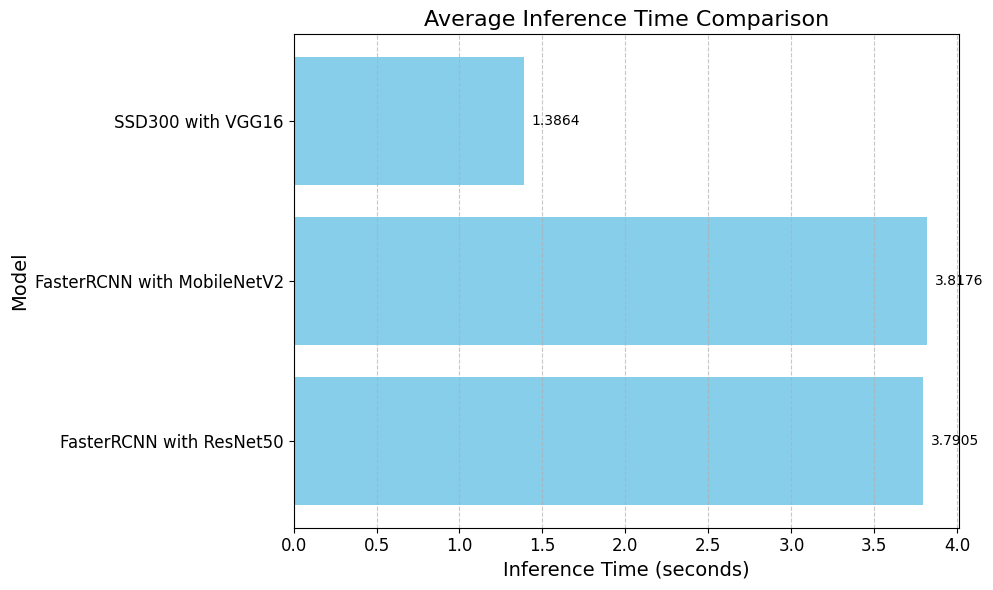

In [83]:
import pandas as pd

data = {'Model': model_names, 'Inference Time (seconds)': avg_times}
df = pd.DataFrame(data)

# Print the DataFrame
print(df)

# Create a beautiful bar plot
plt.figure(figsize=(10, 6))
plt.barh(df['Model'], df['Inference Time (seconds)'], color='skyblue')
plt.xlabel('Inference Time (seconds)', fontsize=14)
plt.ylabel('Model', fontsize=14)
plt.title('Average Inference Time Comparison', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Annotate the bars with the values
for index, value in enumerate(df['Inference Time (seconds)']):
    plt.text(value + 0.05, index, f'{value:.4f}', fontsize=10, va='center', color='black')

plt.tight_layout()
plt.show()

### **8.3 Displaying Average Inference Times with PrettyTable**

We begin by presenting the average inference times using a `PrettyTable`. The table displays the models' names along with their corresponding average inference times in seconds.

+------------------+--------------------------+
|      Model       | Inference Time (seconds) |
+------------------+--------------------------+
|    FasterRCNN    |          3.7905          |
|  with ResNet50   |                          |
|    FasterRCNN    |          3.8176          |
| with MobileNetV2 |                          |
|      SSD300      |          1.3864          |
|    with VGG16    |                          |
+------------------+--------------------------+


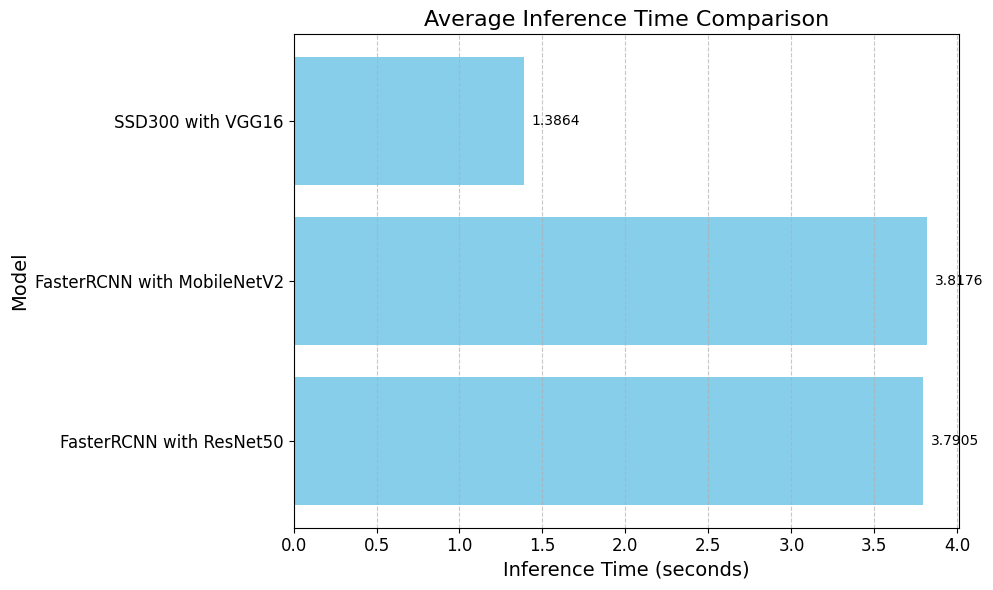

In [84]:
import torch
import time
import pandas as pd
import matplotlib.pyplot as plt
from prettytable import PrettyTable

model_names = ['FasterRCNN\nwith ResNet50', 'FasterRCNN\nwith MobileNetV2', 'SSD300\nwith VGG16']

inference_times = avg_times


# Create a PrettyTable
table = PrettyTable()
table.field_names = ["Model", "Inference Time (seconds)"]
for model_name, avg_time in zip(model_names, inference_times):
    table.add_row([model_name, f"{avg_time:.4f}"])

# Print the PrettyTable
print(table)

# Create a beautiful bar plot with multiline model names
plt.figure(figsize=(10, 6))
plt.barh(df['Model'], df['Inference Time (seconds)'], color='skyblue')
plt.xlabel('Inference Time (seconds)', fontsize=14)
plt.ylabel('Model', fontsize=14)
plt.title('Average Inference Time Comparison', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Annotate the bars with the values
for index, value in enumerate(df['Inference Time (seconds)']):
    plt.text(value + 0.05, index, f'{value:.4f}', fontsize=10, va='center', color='black')

plt.tight_layout()
plt.show()
